In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
df = pd.read_excel("Online Retail.xlsx")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:

df = df.dropna(subset=['CustomerID'])

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [ ]:

snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)


rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
}).reset_index()

rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm_data = rfm_data[rfm_data['Monetary'] > 0]


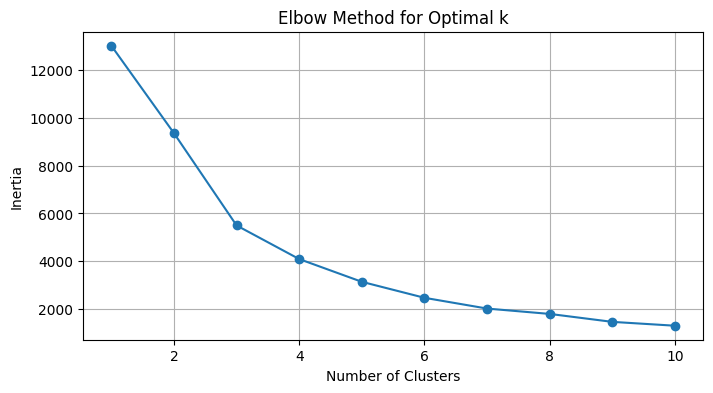

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = rfm_data[['Recency', 'Frequency', 'Monetary']]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(features_scaled)
    inertia.append(km.inertia_)


plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [ ]:

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['Segment'] = kmeans.fit_predict(features_scaled)

segment_summary = rfm_data.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

segment_summary.round(2)


,Recency,Frequency,Monetary,CustomerCount
Segment,,,,
0,43.70,3.68,1359.05,3054
1,248.08,1.55,480.62,1067
2,7.38,82.54,127338.31,13
3,15.50,22.33,12709.09,204


Regular buyers with moderate spend — keep engaged with offers

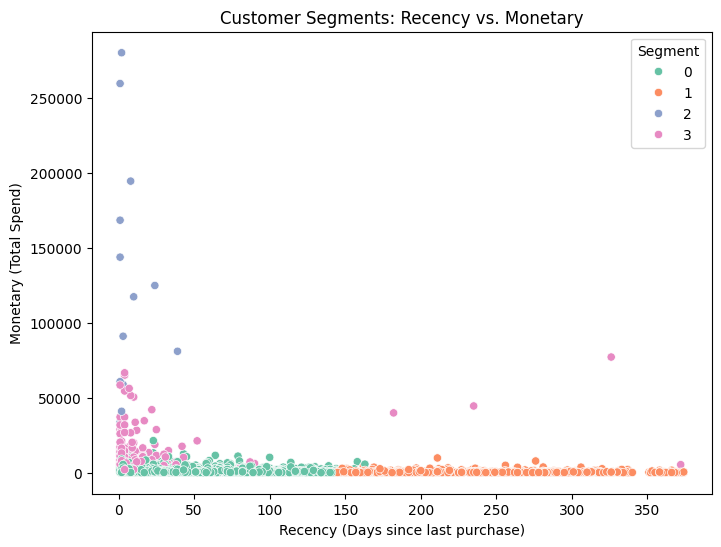

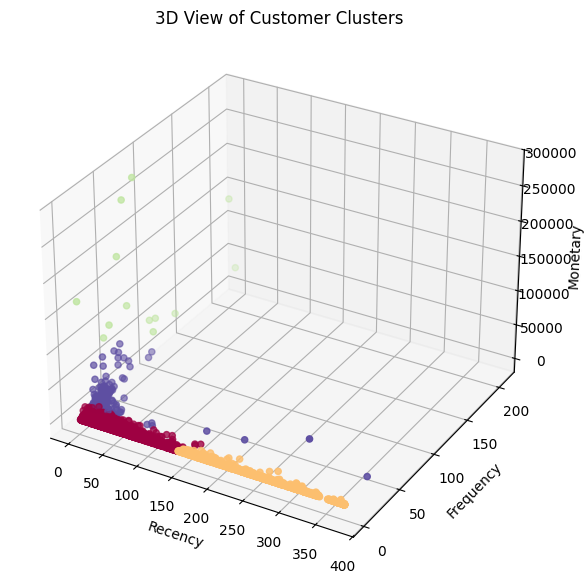

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_data, x='Recency', y='Monetary', hue='Segment', palette='Set2')
plt.title('Customer Segments: Recency vs. Monetary')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Spend)')
plt.show()


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_data['Recency'], rfm_data['Frequency'], rfm_data['Monetary'],
           c=rfm_data['Segment'], cmap='Spectral')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D View of Customer Clusters')
plt.show()


Inactive, low-value customers — target with win-back campaigns.

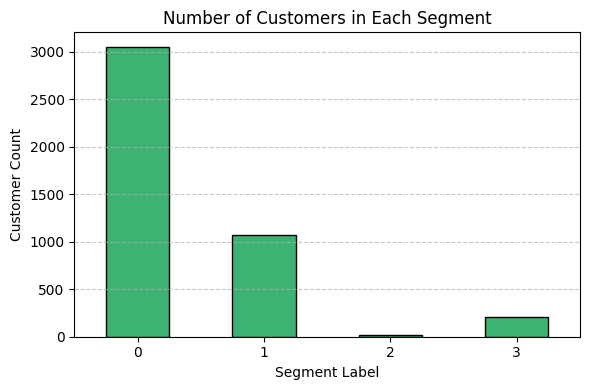

In [ ]:
import matplotlib.pyplot as plt
segment_summary['CustomerCount'] = segment_summary['CustomerCount'].astype(int)  # Ensure it's numeric
plt.figure(figsize=(6, 4))
segment_summary['CustomerCount'].plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Number of Customers in Each Segment')
plt.xlabel('Segment Label')
plt.ylabel('Customer Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


VIP customers — recent, frequent, and high-spending — reward and retain.

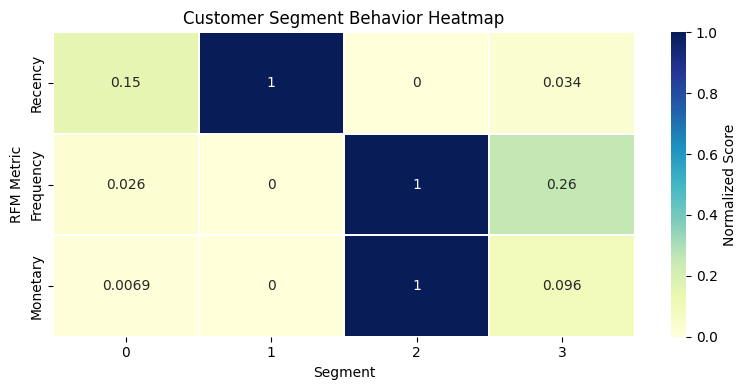

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_means = segment_summary[['Recency', 'Frequency', 'Monetary']]
normalized_rfm = rfm_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
plt.figure(figsize=(8, 4))
sns.heatmap(normalized_rfm.T, annot=True, cmap='YlGnBu', linewidths=0.3, cbar_kws={'label': 'Normalized Score'})
plt.title('Customer Segment Behavior Heatmap')
plt.xlabel('Segment')
plt.ylabel('RFM Metric')
plt.tight_layout()
plt.show()


Loyal and promising — upsell to grow them into VIPs.